# Project Storm: Map of Hurricane Frequency by County

This notebook visualizes which US counties have recorded hurricane impacts based on the `county_events.csv` data.

**Data Requirements:**
1.  `county_events.csv`: Output from the `map_events_to_counties.py` script, containing `county_geoid` and `event_type`.
2.  **US County Polygon File:** A Shapefile (`.shp`) or GeoJSON (`.geojson`) containing county boundary polygons and a county identifier (like `GEOID`, `FIPS`, etc.) that matches the `county_geoid` format in `county_events.csv`. **Update `COUNTY_SHAPEFILE_PATH` below.**

**Visualization:**
- Counties with **zero** recorded hurricane hits will be one color.
- Counties with **one or more** recorded hurricane hits will be another color.

In [1]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import logging
import numpy as np

# --- Configuration ---

# !!! IMPORTANT: UPDATE THIS PATH to your county polygon file !!!
# Example paths: "data/geospatial/tl_2023_us_county.shp" or "data/geospatial/us_counties.geojson"
COUNTY_SHAPEFILE_PATH = "../data/geospatial/tl_2024_us_county.shp" # <-- CHANGE THIS

# Name of the column in your shapefile that contains the 5-digit County GEOID/FIPS
# Common names: 'GEOID', 'FIPS', 'COUNTYFP', 'GEOID20' etc. Check your file's properties.
GEOID_COLUMN_IN_SHAPEFILE = "GEOID" # <-- CHANGE THIS if needed

# Path to your event data
COUNTY_EVENTS_PATH = "../output/final/county_events.csv"

# Output directory for the map image
VIS_OUTPUT_DIR = "../output/visualizations"
os.makedirs(VIS_OUTPUT_DIR, exist_ok=True)

# --- Setup Logger ---
LOG_FILE = "../logs/map_log.log"
logger = logging.getLogger("MapLogger")
logger.setLevel(logging.INFO)

if not logger.handlers:
    # File handler
    fh = logging.FileHandler(LOG_FILE, mode='w')
    fh.setLevel(logging.INFO)
    fh_formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
    fh.setFormatter(fh_formatter)
    logger.addHandler(fh)
    # Console handler
    sh = logging.StreamHandler()
    sh.setLevel(logging.INFO)
    sh_formatter = logging.Formatter("[%(asctime)s] [%(levelname)s] %(name)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S")
    sh.setFormatter(sh_formatter)
    logger.addHandler(sh)

logger.info("--- Map Notebook Setup Complete ---")

[2025-04-08 19:37:37] [INFO] MapLogger - --- Map Notebook Setup Complete ---


In [2]:
# --- Load County Polygon Geometries ---
logger.info(f"Loading county polygons from: {COUNTY_SHAPEFILE_PATH}")
conus_gdf = None # Initialize

try:
    gdf_counties = gpd.read_file(COUNTY_SHAPEFILE_PATH)
    logger.info(f"Successfully loaded shapefile with {len(gdf_counties)} geometries.")
    logger.info(f"Columns available in shapefile: {gdf_counties.columns.tolist()}")

    # --- Data Cleaning and Preparation ---
    # 1. Check for GEOID column
    if GEOID_COLUMN_IN_SHAPEFILE not in gdf_counties.columns:
        logger.error(f"Specified GEOID column '{GEOID_COLUMN_IN_SHAPEFILE}' not found in shapefile.")
        raise ValueError(f"GEOID column '{GEOID_COLUMN_IN_SHAPEFILE}' not found.")

    # 2. Rename GEOID column to 'county_geoid' for consistency
    gdf_counties.rename(columns={GEOID_COLUMN_IN_SHAPEFILE: 'county_geoid'}, inplace=True)

    # 3. Ensure 'county_geoid' is a string and 5-digit padded
    gdf_counties['county_geoid'] = gdf_counties['county_geoid'].astype(str).str.strip().str.zfill(5)
    logger.info("Renamed GEOID column and ensured it's a 5-digit string.")

    # 4. Check Coordinate Reference System (CRS) and Reproject if necessary
    if gdf_counties.crs is None:
        logger.warning("Shapefile has no CRS defined. Assuming WGS84 (EPSG:4326).")
        gdf_counties.set_crs("EPSG:4326", inplace=True)
    logger.info(f"Original CRS: {gdf_counties.crs}")

    # Reproject to a suitable US projection (Albers Equal Area Conic)
    target_crs = "EPSG:5070"
    logger.info(f"Reprojecting counties to {target_crs}...")
    gdf_counties = gdf_counties.to_crs(target_crs)
    logger.info(f"Reprojection complete. Current CRS: {gdf_counties.crs}")

    # --- 5. Filter to CONUS (Exclude AK, HI, Territories) ---
    gdf_counties['state_fips'] = gdf_counties['county_geoid'].str[:2]
    # Define FIPS codes to exclude
    # State FIPS: AK=02, HI=15
    # Territory FIPS often >= 60 (e.g., AS=60, GU=66, MP=69, PR=72, VI=78)
    exclude_fips_list = ['02', '15'] + [str(f).zfill(2) for f in range(60, 80)]

    conus_gdf = gdf_counties[~gdf_counties['state_fips'].isin(exclude_fips_list)].copy()
    logger.info(f"Filtered to {len(conus_gdf)} CONUS counties (Excluded AK, HI, Territories).")
    # --- End Filter ---

    print(f"Loaded and prepared {len(conus_gdf)} CONUS county geometries.")
    display(conus_gdf.head())

except Exception as e:
    logger.exception(f"Failed to load or process county shapefile: {e}")
    # conus_gdf remains None

[2025-04-08 19:37:37] [INFO] MapLogger - Loading county polygons from: ../data/geospatial/tl_2024_us_county.shp
[2025-04-08 19:37:38] [INFO] MapLogger - Successfully loaded shapefile with 3235 geometries.
[2025-04-08 19:37:38] [INFO] MapLogger - Columns available in shapefile: ['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'GEOIDFQ', 'NAME', 'NAMELSAD', 'LSAD', 'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry']
[2025-04-08 19:37:38] [INFO] MapLogger - Renamed GEOID column and ensured it's a 5-digit string.
[2025-04-08 19:37:38] [INFO] MapLogger - Original CRS: EPSG:4269
[2025-04-08 19:37:38] [INFO] MapLogger - Reprojecting counties to EPSG:5070...
[2025-04-08 19:37:41] [INFO] MapLogger - Reprojection complete. Current CRS: EPSG:5070
[2025-04-08 19:37:41] [INFO] MapLogger - Filtered to 3109 CONUS counties (Excluded AK, HI, Territories).


Loaded and prepared 3109 CONUS county geometries.


,STATEFP,COUNTYFP,COUNTYNS,county_geoid,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,state_fips
0,31,039,00835841,31039,0500000US31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477563042,10772508,+41.9158651,-096.7885168,"POLYGON ((-45789.897 2091906.945, -45790.282 2...",31
1,53,069,01513275,53069,0500000US53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680980773,61564428,+46.2946377,-123.4244583,"POLYGON ((-2112099.717 2896531.517, -2112091.3...",53
2,35,011,00933054,35011,0500000US35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818941,29090018,+34.3592729,-104.3686961,"POLYGON ((-813349.146 1263001.929, -813347.645...",35
3,31,109,00835876,31109,0500000US31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169269508,22850511,+40.7835474,-096.6886584,"POLYGON ((-57537.721 1945810.157, -58147.475 1...",31
4,31,129,00835886,31129,0500000US31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645201,1718484,+40.1764918,-098.0468422,"POLYGON ((-192070.667 1902541.611, -192063.577...",31


In [3]:
# --- Load Event Data and Calculate Hurricane Frequency ---
logger.info(f"Loading event data from: {COUNTY_EVENTS_PATH}")
gdf_merged = None # Initialize

if conus_gdf is None: # Use the CONUS geodataframe
     logger.error("CONUS County geometries failed to load. Cannot proceed.")
else:
    try:
        df_county_events = pd.read_csv(COUNTY_EVENTS_PATH, dtype={'county_geoid': str}) # Load geoid as string
        logger.info(f"Loaded {len(df_county_events)} event records.")

        # Filter for hurricane events
        df_hurricanes = df_county_events[df_county_events['event_type'] == 'hurricane'].copy()
        logger.info(f"Filtered {len(df_hurricanes)} hurricane event records.")

        # Calculate frequency per county
        df_hurricanes['county_geoid'] = df_hurricanes['county_geoid'].astype(str).str.strip().str.zfill(5)
        hurricane_counts = df_hurricanes['county_geoid'].value_counts().reset_index()
        hurricane_counts.columns = ['county_geoid', 'hurricane_hits']
        logger.info(f"Calculated hurricane hits for {len(hurricane_counts)} counties.")

        # --- Merge counts onto CONUS geometries ---
        logger.info("Merging hurricane counts onto CONUS county geometries...")
        # Use left merge to keep all CONUS counties, filling non-hits with 0
        gdf_merged = conus_gdf.merge(hurricane_counts, on='county_geoid', how='left') # Merge onto conus_gdf
        gdf_merged['hurricane_hits'] = gdf_merged['hurricane_hits'].fillna(0).astype(int)
        logger.info("Merge complete. Filled NaN counts with 0.")

        # Create binary 'hit' column (still useful for potential checks)
        gdf_merged['hurricane_hit_binary'] = (gdf_merged['hurricane_hits'] > 0).astype(int)
        hits_count = (gdf_merged['hurricane_hit_binary'] == 1).sum()
        logger.info(f"Generated hit status: {hits_count} CONUS counties have >= 1 hit.")

        # --- Adjust columns for display ---
        print("CONUS GeoDataFrame head after merging counts:")
        cols_to_display = ['county_geoid', 'hurricane_hits', 'hurricane_hit_binary', 'geometry']
        if 'NAME' in gdf_merged.columns: cols_to_display.insert(1, 'NAME')
        # Use the state FIPS column we created
        if 'state_fips' in gdf_merged.columns: cols_to_display.insert(2, 'state_fips')

        logger.info(f"Displaying head with columns: {cols_to_display}")
        display(gdf_merged[cols_to_display].head())

    except FileNotFoundError:
        logger.error(f"County events file not found: {COUNTY_EVENTS_PATH}")
        # gdf_merged remains None
    except Exception as e:
        logger.exception(f"Failed to load or process event data: {e}")
        gdf_merged = None # Set to None on error

[2025-04-08 19:37:41] [INFO] MapLogger - Loading event data from: ../output/final/county_events.csv
C:\Users\60864\AppData\Local\Temp\ipykernel_12260\3157264268.py:9: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_county_events = pd.read_csv(COUNTY_EVENTS_PATH, dtype={'county_geoid': str}) # Load geoid as string
[2025-04-08 19:37:41] [INFO] MapLogger - Loaded 209023 event records.
[2025-04-08 19:37:41] [INFO] MapLogger - Filtered 40208 hurricane event records.
[2025-04-08 19:37:41] [INFO] MapLogger - Calculated hurricane hits for 2276 counties.
[2025-04-08 19:37:41] [INFO] MapLogger - Merging hurricane counts onto CONUS county geometries...
[2025-04-08 19:37:41] [INFO] MapLogger - Merge complete. Filled NaN counts with 0.
[2025-04-08 19:37:41] [INFO] MapLogger - Generated hit status: 2198 CONUS counties have >= 1 hit.
[2025-04-08 19:37:41] [INFO] MapLogger - Displaying head with columns: ['county_geoid', 'NAME', 'state_fips', 'h

CONUS GeoDataFrame head after merging counts:


,county_geoid,NAME,state_fips,hurricane_hits,hurricane_hit_binary,geometry
0,31039,Cuming,31,0,0,"POLYGON ((-45789.897 2091906.945, -45790.282 2..."
1,53069,Wahkiakum,53,0,0,"POLYGON ((-2112099.717 2896531.517, -2112091.3..."
2,35011,De Baca,35,0,0,"POLYGON ((-813349.146 1263001.929, -813347.645..."
3,31109,Lancaster,31,1,1,"POLYGON ((-57537.721 1945810.157, -58147.475 1..."
4,31129,Nuckolls,31,1,1,"POLYGON ((-192070.667 1902541.611, -192063.577..."


[2025-04-08 19:37:41] [INFO] MapLogger - Generating CONUS county map with Green-Yellow-Red color scale...
[2025-04-08 19:37:57] [INFO] MapLogger - Map saved successfully to ../output/visualizations\hurricane_hits_conus_map_GrYlRd.png


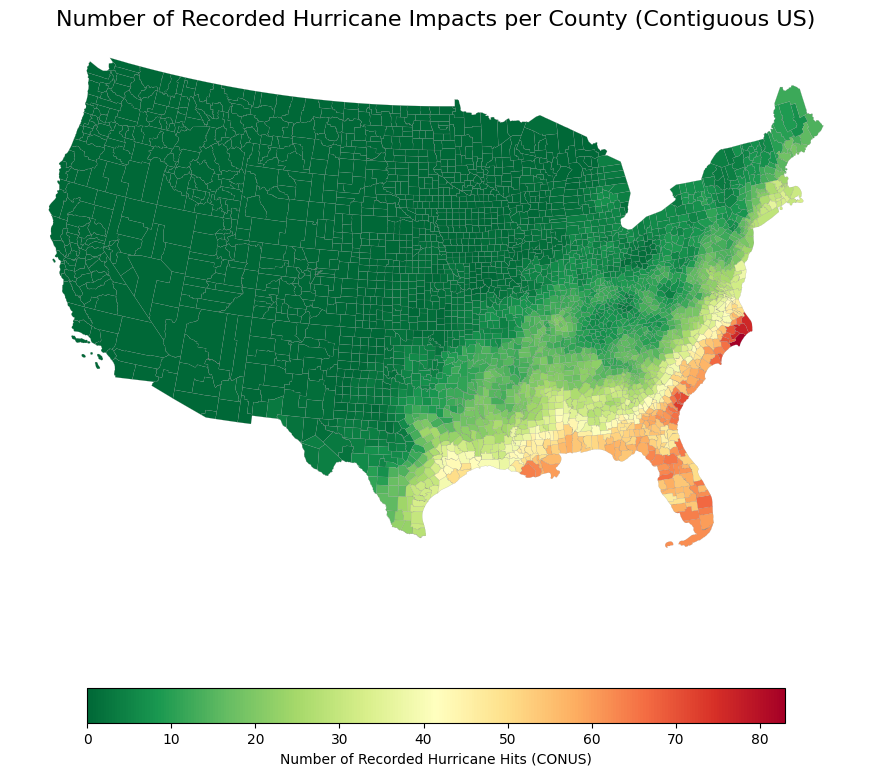

[2025-04-08 19:38:01] [INFO] MapLogger - --- Map Notebook Complete ---


In [4]:
# --- Create the Map ---
logger.info("Generating CONUS county map with Green-Yellow-Red color scale...")

if 'gdf_merged' not in locals() or gdf_merged is None: # Check if gdf_merged exists and is not None
    logger.error("Merged GeoDataFrame ('gdf_merged') is not available. Cannot create map.")
else:
    try:
        fig, ax = plt.subplots(1, 1, figsize=(15, 10))

        # --- Plotting with Continuous Scale ---
        # Use the 'hurricane_hits' column and Green->Yellow->Red colormap ('RdYlGn_r')
        gdf_merged.plot(column='hurricane_hits',
                        cmap='RdYlGn_r',       # Use Red-Yellow-Green reversed map
                        linewidth=0.1,
                        edgecolor='0.5',
                        legend=True,
                        legend_kwds={
                            'label': "Number of Recorded Hurricane Hits (CONUS)",
                            'orientation': "horizontal",
                            'shrink': 0.6
                        },
                        ax=ax,
                        missing_kwds={ # Explicitly color missing data (e.g. if merge failed unexpectedly)
                           "color": "lightgrey",
                           "label": "No Data",
                        }
                       )
        # Note: With 'RdYlGn_r', 0 hits will be green, highest hits will be red.

        # --- Optional: Add State Borders ---
        # (Keep the optional state border plotting code if desired)
        # logger.info("Attempting to add state borders overlay...")
        # try:
        #     # Assuming you have a CONUS states shapefile, load and project it
        #     gdf_states = gpd.read_file("path/to/your/conus_states.shp") # Provide path
        #     gdf_states = gdf_states.to_crs(gdf_merged.crs) # Match projection
        #     gdf_states.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)
        #     logger.info("Added state borders overlay.")
        # except Exception as state_e:
        #     logger.warning(f"Could not load or plot state borders: {state_e}")
        # --- End Optional ---

        # Customize plot
        ax.set_axis_off()
        ax.set_title('Number of Recorded Hurricane Impacts per County (Contiguous US)', fontsize=16)

        # Save the figure
        map_filename = os.path.join(VIS_OUTPUT_DIR, 'hurricane_hits_conus_map_GrYlRd.png')
        plt.savefig(map_filename, dpi=300, bbox_inches='tight')
        logger.info(f"Map saved successfully to {map_filename}")

        plt.show()

    except Exception as e:
        logger.exception(f"An error occurred during map plotting: {e}")

logger.info("--- Map Notebook Complete ---")